In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('NYPD_Complaint_Data_Current__Year_To_Date_.csv', delimiter = ',')

In [3]:
df.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,857927015,10.0,MANHATTAN,01/29/2019,16:37:00,01/29/2019,16:45:00,COMPLETED,NaN,NaN,...,M,NaN,UNKNOWN,UNKNOWN,M,984140.0,211709.0,40.747777,-74.000398,"(40.747777093, -74.000398443)"
1,479254687,101.0,QUEENS,03/29/2019,17:00:00,03/29/2019,17:10:00,COMPLETED,NaN,NaN,...,M,NaN,25-44,BLACK,F,1054076.0,157437.0,40.598538,-73.748560,"(40.598537593, -73.748559596)"
2,320007604,41.0,BRONX,02/06/2019,02:00:00,NaN,NaN,COMPLETED,NaN,NaN,...,M,NaN,UNKNOWN,UNKNOWN,D,1011589.0,237996.0,40.819886,-73.901227,"(40.819885621, -73.901226998)"
3,746022144,68.0,BROOKLYN,01/08/2019,22:49:00,01/08/2019,22:52:00,COMPLETED,NaN,NaN,...,M,NaN,UNKNOWN,UNKNOWN,E,984439.0,166855.0,40.624663,-73.999321,"(40.624663129, -73.999320591)"
4,593941718,45.0,BRONX,03/17/2019,05:00:00,03/17/2019,05:20:00,COMPLETED,NaN,NaN,...,M,NaN,25-44,BLACK HISPANIC,F,1027255.0,244817.0,40.838545,-73.844583,"(40.838544913, -73.844582889)"


In [5]:
# drop null values, these are columns with mostly null values
df = df.drop(columns=['STATION_NAME', 'TRANSIT_DISTRICT', 'PARKS_NM', 'HOUSING_PSA', 'HADEVELOPT'])

In [7]:
# and then drop rows with nulls
df = df.dropna()
df.shape

(121909, 30)

In [8]:
# target will be BORO_NM, or name of borough which the complaint happened in
df['BORO_NM'].describe()

count       121909
unique           5
top       BROOKLYN
freq         35755
Name: BORO_NM, dtype: object

In [9]:
df['BORO_NM'].value_counts()

BROOKLYN         35755
MANHATTAN        31872
QUEENS           25501
BRONX            24006
STATEN ISLAND     4775
Name: BORO_NM, dtype: int64

In [13]:
# i personally spend more time in manhattan and have always wondered if it was safer there
# so making new column for whether the crime happened in manhattan or not, and then use this as my target
df['IS_MANHATTAN'] = np.where(df['BORO_NM'].str.contains("MANHATTAN"), '1', '0')

In [15]:
# so the baseline for majority is .73 for not in manhattan
df['IS_MANHATTAN'].value_counts(normalize=True)

0    0.738559
1    0.261441
Name: IS_MANHATTAN, dtype: float64

In [16]:
# now lets clean the data more, drop columns with leakage, so any columns location related info
df = df.drop(columns=['ADDR_PCT_CD', 'PATROL_BORO', 'Longitude', 'Latitude', 'Y_COORD_CD', 'Lat_Lon', 'X_COORD_CD'])

In [18]:
# data looks good to work with, now let's start splitting and modeling
from sklearn.model_selection import train_test_split

train, test = train_test_split(df)

In [21]:
X_train = train.drop(columns='IS_MANHATTAN')
y_train = train['IS_MANHATTAN']

X_test = test.drop(columns='IS_MANHATTAN')
y_test = test['IS_MANHATTAN']

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((91431, 23), (30478, 23), (91431,), (30478,))

In [ ]:
# classification problem

In [147]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

features = ['PREM_TYP_DESC', 'VIC_RACE', 'PD_CD', 'PD_DESC', 'LOC_OF_OCCUR_DESC', 'KY_CD', 'OFNS_DESC', 'VIC_SEX', 'JURIS_DESC', 'SUSP_RACE', 'CMPLNT_FR_DT', 'VIC_AGE_GROUP', 'SUSP_AGE_GROUP', 'SUSP_SEX', 'CMPLNT_TO_TM', 'JURISDICTION_CODE', 'CMPLNT_FR_TM', 'LAW_CAT_CD', 'RPT_DT']

pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

cross_val_score(pipe, X_train[features], y_train, cv=20, scoring='roc_auc')

array([0.74224507, 0.7194177 , 0.72998132, 0.74227484, 0.73970609,
       0.74266691, 0.7259419 , 0.73093167, 0.72304409, 0.74303579,
       0.73574543, 0.73961704, 0.73735441, 0.73162382, 0.75108969,
       0.72208715, 0.73548092, 0.72110931, 0.71548743, 0.7207815 ])

In [148]:
from sklearn.metrics import roc_auc_score
pipe.fit(X_train[features], y_train)
y_pred_proba = pipe.predict_proba(X_test[features])[:, 1]
roc_auc_score(y_test, y_pred_proba)

0.7317795471740193

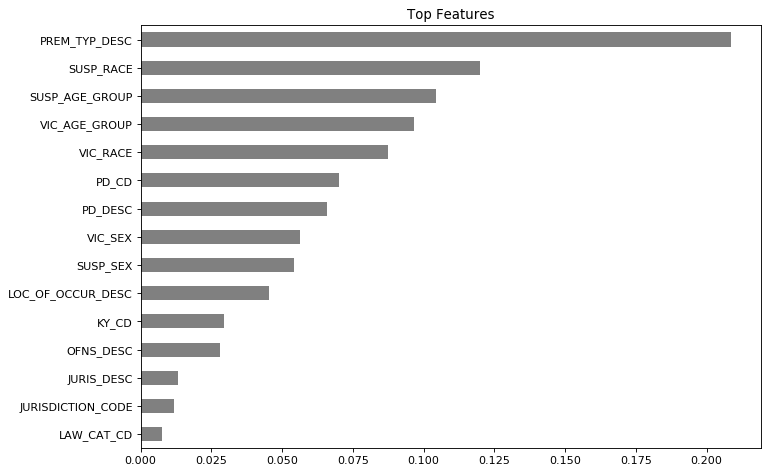

In [146]:
# could be better
# let's make a few more visualizations
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline
rf = pipe.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, features)
figure(num=None, figsize=(10, 7), dpi=80)
plt.title(f'Top Features')
importances.sort_values().plot.barh(color='grey');


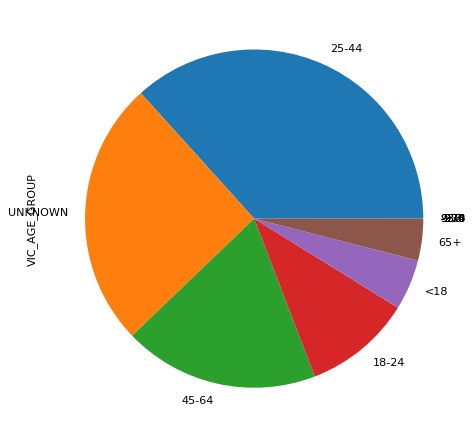

In [150]:
figure(num=None, figsize=(10, 7), dpi=80)
df.VIC_AGE_GROUP.value_counts().plot(kind='pie')

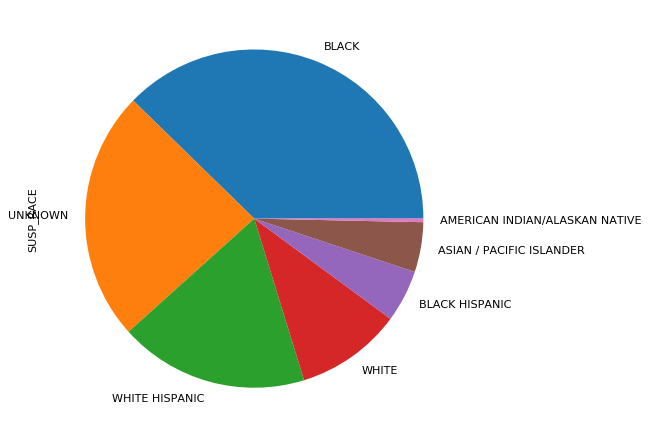

In [135]:
figure(num=None, figsize=(10, 7), dpi=80)
df_isnot.SUSP_RACE.value_counts().plot(kind='pie')

In [109]:
is_manh = df['IS_MANHATTAN']=='1'

In [112]:
isnot_manh = df['IS_MANHATTAN']=='0'

In [111]:
df_manh = df[is_manh]
df_manh.shape

(31872, 24)

In [114]:
df_manh.head()

,CMPLNT_NUM,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,JURISDICTION_CODE,JURIS_DESC,KY_CD,...,PD_DESC,PREM_TYP_DESC,RPT_DT,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,IS_MANHATTAN
5,613547550,MANHATTAN,02/22/2019,13:35:00,02/22/2019,2019-10-25 17:00:00,COMPLETED,0.0,N.Y. POLICE DEPT,578,...,"HARASSMENT,SUBD 3,4,5",RESIDENCE - APT. HOUSE,02/22/2019,UNKNOWN,UNKNOWN,M,45-64,BLACK,F,1
12,827038864,MANHATTAN,03/19/2019,20:00:00,03/19/2019,2019-10-25 20:30:00,COMPLETED,0.0,N.Y. POLICE DEPT,344,...,ASSAULT 3,STREET,03/20/2019,25-44,WHITE,M,25-44,WHITE,F,1
22,877424333,MANHATTAN,11/11/2018,12:00:00,01/02/2019,2019-10-25 17:20:00,COMPLETED,0.0,N.Y. POLICE DEPT,361,...,AGGRAVATED HARASSMENT 2,RESIDENCE - APT. HOUSE,01/04/2019,25-44,WHITE,F,45-64,WHITE,M,1
36,756624425,MANHATTAN,03/08/2019,08:30:00,03/08/2019,2019-10-25 08:35:00,COMPLETED,0.0,N.Y. POLICE DEPT,361,...,AGGRAVATED HARASSMENT 2,RESIDENCE - APT. HOUSE,03/09/2019,UNKNOWN,BLACK,M,18-24,WHITE HISPANIC,F,1
47,646876813,MANHATTAN,03/11/2019,13:24:00,03/11/2019,2019-10-25 13:38:00,COMPLETED,0.0,N.Y. POLICE DEPT,113,...,"FORGERY,ETC.,UNCLASSIFIED-FELO",PARKING LOT/GARAGE (PUBLIC),03/11/2019,25-44,BLACK HISPANIC,M,UNKNOWN,UNKNOWN,E,1


In [113]:
df_isnot = df[isnot_manh]
df_isnot.shape

(90037, 24)

In [115]:
df_isnot.head()

,CMPLNT_NUM,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,JURISDICTION_CODE,JURIS_DESC,KY_CD,...,PD_DESC,PREM_TYP_DESC,RPT_DT,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,IS_MANHATTAN
1,479254687,QUEENS,03/29/2019,17:00:00,03/29/2019,2019-10-25 17:10:00,COMPLETED,0.0,N.Y. POLICE DEPT,107,...,"BURGLARY,RESIDENCE,DAY",RESIDENCE - APT. HOUSE,03/29/2019,UNKNOWN,BLACK,M,25-44,BLACK,F,0
6,585652917,QUEENS,02/01/2019,10:00:00,02/01/2019,2019-10-25 10:30:00,COMPLETED,0.0,N.Y. POLICE DEPT,578,...,"HARASSMENT,SUBD 3,4,5",RESIDENCE - APT. HOUSE,02/02/2019,18-24,BLACK,M,18-24,BLACK,F,0
7,407860526,QUEENS,01/27/2019,04:00:00,01/27/2019,2019-10-25 04:15:00,COMPLETED,0.0,N.Y. POLICE DEPT,105,...,"ROBBERY,NECKCHAIN/JEWELRY",STREET,01/27/2019,UNKNOWN,BLACK,M,25-44,WHITE HISPANIC,M,0
9,746680655,STATEN ISLAND,03/23/2019,20:06:00,03/23/2019,2019-10-25 22:30:00,COMPLETED,0.0,N.Y. POLICE DEPT,341,...,"LARCENY,PETIT FROM OPEN AREAS,",RESIDENCE-HOUSE,03/24/2019,UNKNOWN,UNKNOWN,U,45-64,BLACK,F,0
10,513320708,BROOKLYN,01/14/2019,17:35:00,01/14/2019,2019-10-25 17:40:00,COMPLETED,2.0,N.Y. HOUSING POLICE,106,...,"ASSAULT 2,1,UNCLASSIFIED",RESIDENCE - PUBLIC HOUSING,01/14/2019,18-24,WHITE HISPANIC,F,18-24,WHITE HISPANIC,M,0


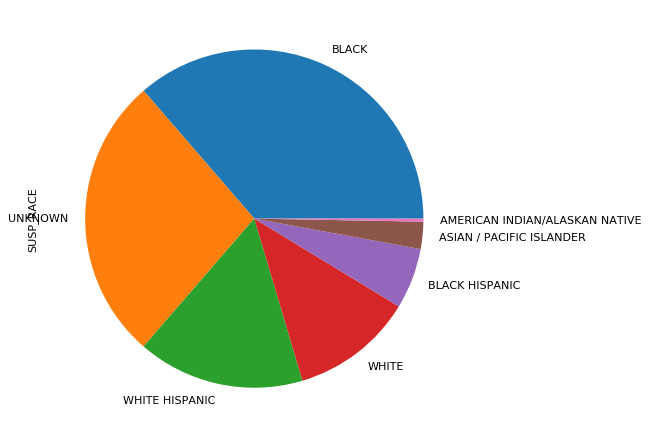

In [116]:
figure(num=None, figsize=(10, 7), dpi=80)
df_manh.SUSP_RACE.value_counts().plot(kind='pie')

In [151]:
df.CMPLNT_FR_TM.value_counts(normalize=True)

12:00:00    0.024887
15:00:00    0.020688
16:00:00    0.017858
18:00:00    0.017644
17:00:00    0.017595
              ...   
06:32:00    0.000016
06:16:00    0.000016
05:52:00    0.000016
05:31:00    0.000008
05:06:00    0.000008
Name: CMPLNT_FR_TM, Length: 1440, dtype: float64

In [117]:
df_manh.SUSP_RACE.value_counts(normalize=True)

BLACK                             0.363548
UNKNOWN                           0.272841
WHITE HISPANIC                    0.159607
WHITE                             0.117125
BLACK HISPANIC                    0.057951
ASIAN / PACIFIC ISLANDER          0.026042
AMERICAN INDIAN/ALASKAN NATIVE    0.002887
Name: SUSP_RACE, dtype: float64

In [118]:
df.SUSP_RACE.value_counts(normalize=True)

BLACK                             0.373516
UNKNOWN                           0.248308
WHITE HISPANIC                    0.175369
WHITE                             0.105530
BLACK HISPANIC                    0.052039
ASIAN / PACIFIC ISLANDER          0.041974
AMERICAN INDIAN/ALASKAN NATIVE    0.003265
Name: SUSP_RACE, dtype: float64

In [119]:
df_isnot.SUSP_RACE.value_counts(normalize=True)

BLACK                             0.377045
UNKNOWN                           0.239624
WHITE HISPANIC                    0.180948
WHITE                             0.101425
BLACK HISPANIC                    0.049946
ASIAN / PACIFIC ISLANDER          0.047614
AMERICAN INDIAN/ALASKAN NATIVE    0.003399
Name: SUSP_RACE, dtype: float64

In [158]:
pd.options.display.max_rows = 99

In [159]:
df.PREM_TYP_DESC.value_counts(normalize=True)

RESIDENCE - APT. HOUSE          0.282366
STREET                          0.160382
RESIDENCE-HOUSE                 0.117506
RESIDENCE - PUBLIC HOUSING      0.098549
CHAIN STORE                     0.047191
COMMERCIAL BUILDING             0.030539
OTHER                           0.030531
DEPARTMENT STORE                0.028931
GROCERY/BODEGA                  0.023214
DRUG STORE                      0.020761
RESTAURANT/DINER                0.016356
BAR/NIGHT CLUB                  0.013773
CLOTHING/BOUTIQUE               0.012329
PUBLIC SCHOOL                   0.012263
HOTEL/MOTEL                     0.008186
FAST FOOD                       0.008129
FOOD SUPERMARKET                0.007735
HOSPITAL                        0.006702
PUBLIC BUILDING                 0.005184
BANK                            0.004257
STORE UNCLASSIFIED              0.004151
BEAUTY & NAIL SALON             0.003855
PARK/PLAYGROUND                 0.003798
SMALL MERCHANT                  0.003626
GYM/FITNESS FACI

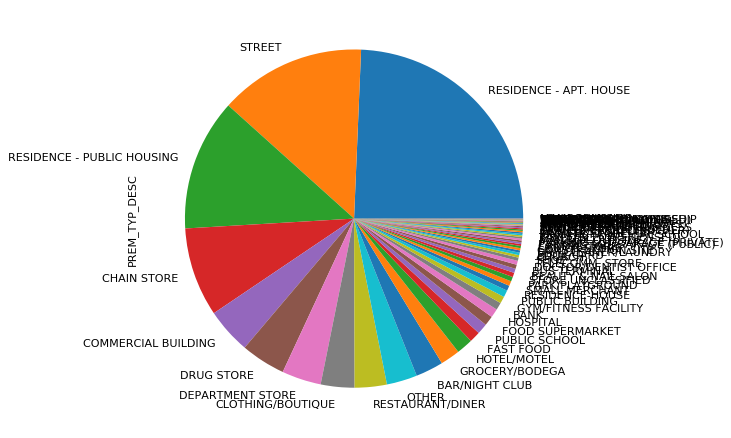

In [126]:
figure(num=None, figsize=(10, 7), dpi=80)
df_manh.PREM_TYP_DESC.value_counts().plot(kind='pie')

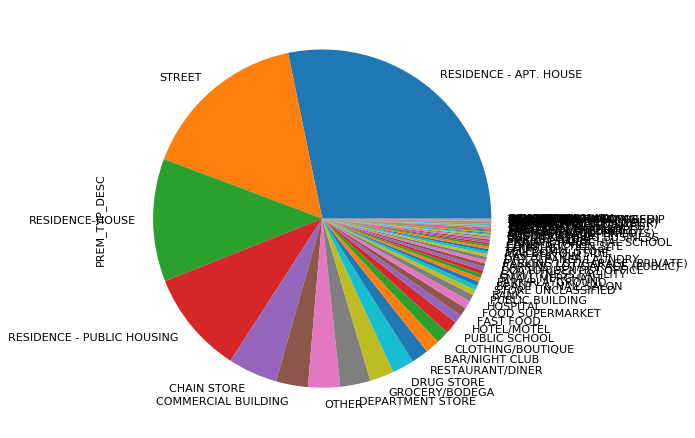

In [133]:
figure(num=None, figsize=(10, 7), dpi=80)
df.PREM_TYP_DESC.value_counts().plot(kind='pie')

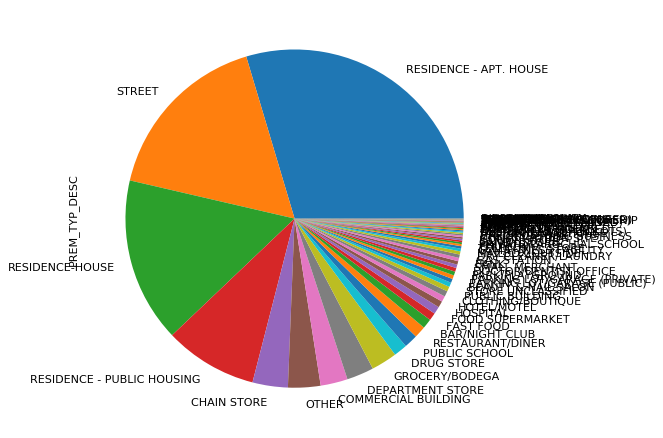

In [134]:
figure(num=None, figsize=(10, 7), dpi=80)
df_isnot.PREM_TYP_DESC.value_counts().plot(kind='pie')

In [160]:
df_manh.PREM_TYP_DESC.value_counts(normalize=True)

RESIDENCE - APT. HOUSE          0.243380
STREET                          0.140029
RESIDENCE - PUBLIC HOUSING      0.125910
CHAIN STORE                     0.085153
COMMERCIAL BUILDING             0.043612
DRUG STORE                      0.042639
DEPARTMENT STORE                0.037588
CLOTHING/BOUTIQUE               0.032191
RESTAURANT/DINER                0.030685
OTHER                           0.029179
BAR/NIGHT CLUB                  0.026512
GROCERY/BODEGA                  0.018794
HOTEL/MOTEL                     0.015719
FAST FOOD                       0.010448
PUBLIC SCHOOL                   0.010166
FOOD SUPERMARKET                0.009287
HOSPITAL                        0.008409
BANK                            0.007059
GYM/FITNESS FACILITY            0.006620
PUBLIC BUILDING                 0.006589
RESIDENCE-HOUSE                 0.005020
SMALL MERCHANT                  0.004549
PARK/PLAYGROUND                 0.004298
STORE UNCLASSIFIED              0.004142
BEAUTY & NAIL SA

In [161]:
df_isnot.PREM_TYP_DESC.value_counts(normalize=True)

RESIDENCE - APT. HOUSE          0.296167
STREET                          0.167587
RESIDENCE-HOUSE                 0.157324
RESIDENCE - PUBLIC HOUSING      0.088863
CHAIN STORE                     0.033753
OTHER                           0.031009
COMMERCIAL BUILDING             0.025912
DEPARTMENT STORE                0.025867
GROCERY/BODEGA                  0.024779
DRUG STORE                      0.013017
PUBLIC SCHOOL                   0.013006
RESTAURANT/DINER                0.011284
BAR/NIGHT CLUB                  0.009263
FAST FOOD                       0.007308
FOOD SUPERMARKET                0.007186
HOSPITAL                        0.006097
HOTEL/MOTEL                     0.005520
CLOTHING/BOUTIQUE               0.005298
PUBLIC BUILDING                 0.004687
STORE UNCLASSIFIED              0.004154
BEAUTY & NAIL SALON             0.003798
PARKING LOT/GARAGE (PUBLIC)     0.003654
PARKING LOT/GARAGE (PRIVATE)    0.003632
PARK/PLAYGROUND                 0.003621
DOCTOR/DENTIST O

In [140]:
df['RPT_DT'] = df['RPT_DT'].astype('datetime64[ns]') 

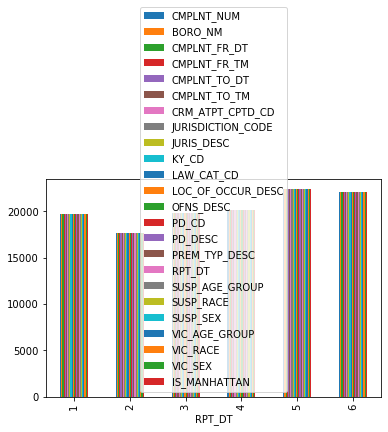

In [143]:
df.groupby(df["RPT_DT"].dt.month).count().plot(kind="bar")